## SetUp the System
- Install PyShark
- Get TShark

In [1]:
%pip install pyshark
%pip install prettytable
!sudo apt-get update
!sudo apt-get install tshark

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease                 
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease               
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease               
Hit:5 https://ppa.launchpadcontent.net/wireshark-dev/stable/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tshark is already the newest version (4.2.2-1~ubuntu22.04.0~ppa2).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


## To make the system asynchrounous

In [2]:
import nest_asyncio
nest_asyncio.apply()

## Imports for Task 1A

In [3]:
import pyshark
import numpy
import matplotlib.pyplot as plt
from prettytable import PrettyTable

## Setting up the files

In [4]:
# Files and their paths
pcap_files = {
    "480p": "pcapture/youtube/youtube480.pcap", 
    "720p": "pcapture/youtube/youtube720.pcap", 
    "1080p": "pcapture/youtube/youtube1080.pcap",
    "1440p": "pcapture/youtube/youtube1440.pcap",
    "2160p": "pcapture/youtube/youtube2160.pcap"
}

## Necessary Functions 

In [5]:
# Total packets captured
def get_packet_count(captured):
    cnt = 0
    for _ in captured:
        cnt += 1
    return cnt

In [6]:
# Extract data from pcap file
def extract_data(pcap_file):
    captured = pyshark.FileCapture(pcap_file)
    return captured

In [7]:
# Number of packets with each IP as destination
def get_ip_count_map(captured):
    ip_cnt = {}
    for packet in captured:
        try:
            if(packet.ip.dst not in ip_cnt):
                ip_cnt[packet.ip.dst] = 1
            else:
                ip_cnt[packet.ip.dst] += 1
        except:
            pass
    return ip_cnt

In [8]:
def set_my_ip(captured):
    ## Most occuring IP as destination is taken as the host IP
    ## This simplifies the process of finding the host IP and avoids hardcoding the host IP address 
    ## as majority of the packets are sent to the host
    
    max_occur_ip = None
    ip_count_map = get_ip_count_map(captured)
    mx_cnt = 0
    for key in ip_count_map.keys():
        if(ip_count_map[key] > mx_cnt):
            mx_cnt = ip_count_map[key]
            max_occur_ip = key
    return max_occur_ip
    

In [9]:
captured1 = extract_data(pcap_files['480p'])
my_ip = set_my_ip(captured1)

## General API syntax :: PyShark

In [10]:
packet = captured1[0]
# Ethernet layer
print("Source MAC:", packet.eth.src)
print("Destination MAC:", packet.eth.dst)

# IP layer
print("Source IP:", packet.ip.src)
print("Destination IP:", packet.ip.dst)

# Protocol information
print("Protocol:", packet.highest_layer)

# Other details
print("Packet Length:", packet.length)
print("Timestamp:", packet.sniff_time)


Source MAC: 00:c8:8b:57:ec:40
Destination MAC: fc:77:74:8e:3f:8c
Source IP: 180.149.60.13
Destination IP: 10.42.81.139
Protocol: QUIC
Packet Length: 868
Timestamp: 2024-02-10 18:52:29.771376


In [11]:
bucket_size = 100 ## in milliseconds
bursty_threshold  = 100 
slot_size = bucket_size / 1000 ## bucket size in seconds
DEBUG = False

In [20]:
# Returns the number of packets per second in each time bucket
def get_packet_buckets(captured):
    exceptions_count = 0
    uplink_packet_buckets = {}
    downlink_packet_buckets = {}
    first_packet_time = None
    for packet in captured:
        try:
            if first_packet_time is None:
                first_packet_time = packet.sniff_time.timestamp()
                
            packet_time = packet.sniff_time.timestamp()
            time_difference_milliseconds = 1000 * (packet_time - first_packet_time)
            
            bucket_id = int(time_difference_milliseconds / bucket_size)
            if(packet.ip.src == my_ip):
                if (bucket_id not in uplink_packet_buckets):
                    uplink_packet_buckets[bucket_id] = 1
                else:
                    uplink_packet_buckets[bucket_id] += 1
            if(packet.ip.dst == my_ip):
                if (bucket_id not in downlink_packet_buckets):
                    downlink_packet_buckets[bucket_id] = 1
                else:
                    downlink_packet_buckets[bucket_id] += 1

        except:
            exceptions_count += 1
            pass
    
    return uplink_packet_buckets, downlink_packet_buckets

In [21]:
# Returns the number of bytes per second in each time bucket and the last packet time
def get_packetsize_buckets(captured):
    exceptions_count = 0
    uplink_packetsize_buckets = {}
    downlink_packetsize_buckets = {}
    first_packet_time = None
    for packet in captured:
        try:
            if first_packet_time is None:
                first_packet_time = packet.sniff_time.timestamp()
            packet_time = packet.sniff_time.timestamp()
            time_difference_milliseconds = 1000 * (packet_time - first_packet_time)
            bucket_id = int(time_difference_milliseconds / bucket_size)
            packet_size_bytes = int(packet.length)
            last_packet_time = packet.sniff_time.timestamp()
            if(packet.ip.src == my_ip):
                if (bucket_id not in uplink_packetsize_buckets):
                    uplink_packetsize_buckets[bucket_id] = packet_size_bytes
                else:
                    uplink_packetsize_buckets[bucket_id] += packet_size_bytes
            if(packet.ip.dst == my_ip):
                if (bucket_id not in downlink_packetsize_buckets):
                    downlink_packetsize_buckets[bucket_id] = packet_size_bytes
                else:
                    downlink_packetsize_buckets[bucket_id] += packet_size_bytes

        except:
            exceptions_count += 1
            pass
    
    for key in uplink_packetsize_buckets.keys():
        uplink_packetsize_buckets[key] /= (1000) # kBps
    for key in downlink_packetsize_buckets.keys():
        downlink_packetsize_buckets[key] /= (1000) # kBps
    
    return uplink_packetsize_buckets, downlink_packetsize_buckets, last_packet_time

In [22]:
def convert_to_per_second(uplink_packet_buckets, downlink_packet_buckets):
    for key in uplink_packet_buckets.keys():
        uplink_packet_buckets[key] /= (slot_size) # packets/s
    for key in downlink_packet_buckets.keys():
        downlink_packet_buckets[key] /= (slot_size) # packets/s
    return uplink_packet_buckets, downlink_packet_buckets

In [23]:
# Returns number of bursty slots and the burst values
def get_bursty_slots(downlink_packet_buckets):
    bursty_slots = []
    for key, val in downlink_packet_buckets.items():
        if(val >= bursty_threshold):
            bursty_slots.append(val)
    return bursty_slots, len(bursty_slots)

In [24]:
def get_plot_lists(uplink_packet_buckets, downlink_packet_buckets, uplink_packetsize_buckets, downlink_packetsize_buckets, num_buckets):
    bucket_index_list = [i for i in range(num_buckets+1)]
    uplink_packet_count_list = []
    uplink_packet_size_list = []
    downlink_packet_count_list = []
    downlink_packet_size_list = []
    for i in bucket_index_list:
        if(i in uplink_packet_buckets.keys()):
            uplink_packet_count_list.append(uplink_packet_buckets[i])
            uplink_packet_size_list.append(uplink_packetsize_buckets[i])
        else:
            uplink_packet_count_list.append(0)
            uplink_packet_size_list.append(0)
        
        if(i in downlink_packet_buckets.keys()):
            downlink_packet_count_list.append(downlink_packet_buckets[i])
            downlink_packet_size_list.append(downlink_packetsize_buckets[i])
        else:
            downlink_packet_count_list.append(0)
            downlink_packet_size_list.append(0)
    
    return bucket_index_list, uplink_packet_count_list, downlink_packet_count_list, uplink_packet_size_list, downlink_packet_size_list

## Setting up Global Definitions for Analysis 

In [25]:
max_buckets = 0
packet_bucket_map = {}
size_bucket_map = {}
for name in pcap_files.keys():
    packet_bucket_map[name] = {}
    size_bucket_map[name] = {}


In [26]:

for file_name, pcap_file in pcap_files.items():
    captured = pyshark.FileCapture(pcap_files[file_name])
    uplink_packet_buckets, downlink_packet_buckets = get_packet_buckets(captured)
    uplink_packetsize_buckets, downlink_packetsize_buckets, last_packet_time = get_packetsize_buckets(captured)
    first_packet_time = captured[0].sniff_time.timestamp()

    total_time_milliseconds = (last_packet_time - first_packet_time) * 1000 ## milliseconds
    num_buckets = int((total_time_milliseconds + bucket_size - 1) / bucket_size)

    full_slots = len(downlink_packet_buckets)
    bursty_slots = 0
    total_slots = num_buckets
    max_buckets = max(num_buckets, max_buckets)

    _, num_bursty_slots = get_bursty_slots(downlink_packet_buckets)
    uplink_packet_buckets, downlink_packet_buckets = convert_to_per_second(uplink_packet_buckets, downlink_packet_buckets)
    uplink_packetsize_buckets, downlink_packetsize_buckets = convert_to_per_second(uplink_packetsize_buckets, downlink_packetsize_buckets)
    if DEBUG: print(total_time_milliseconds, num_bursty_slots, len(uplink_packet_buckets.keys()), len(downlink_packet_buckets.keys()), len(uplink_packetsize_buckets.keys()), len(downlink_packetsize_buckets.keys()), total_slots)
    packet_bucket_map[file_name]['bursty_slots'] = num_bursty_slots
    packet_bucket_map[file_name]['uplink'] = uplink_packet_buckets
    packet_bucket_map[file_name]['downlink'] = downlink_packet_buckets
    size_bucket_map[file_name]['uplink'] = uplink_packetsize_buckets
    size_bucket_map[file_name]['downlink'] = downlink_packetsize_buckets
    packet_bucket_map[file_name]['fraction_bursty'] = num_bursty_slots / total_slots
    


## Plotting the results

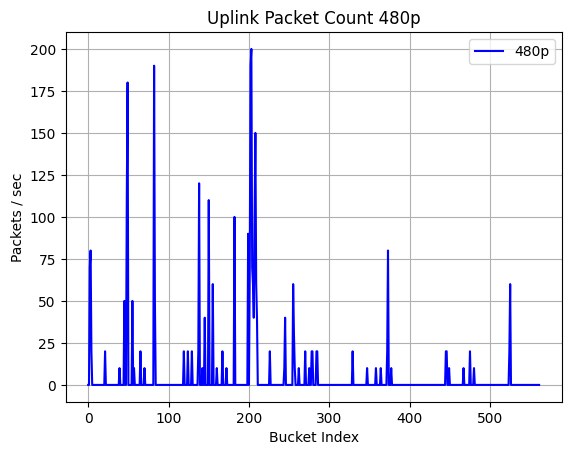

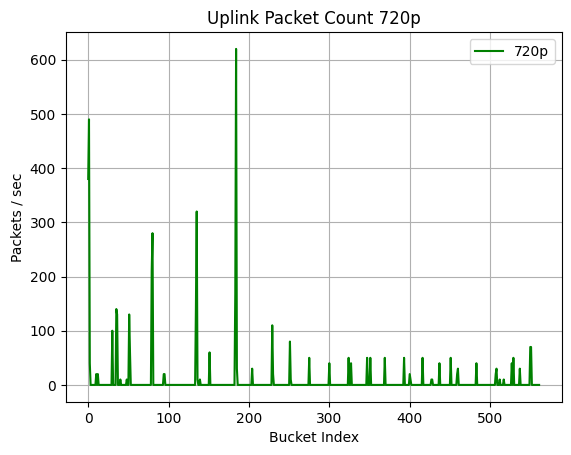

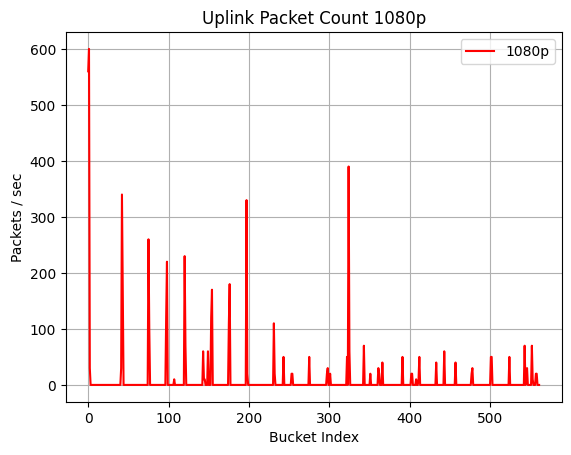

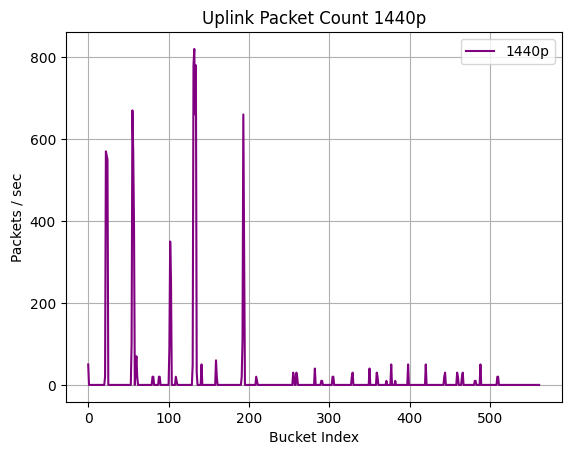

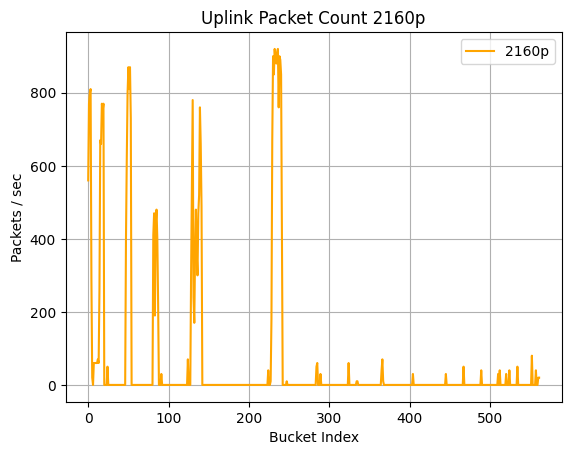

In [38]:

bucket_index_list = [i for i in range(max_buckets)]

# Define colors
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Initialize color index
color_idx = 0

for file_name in packet_bucket_map.keys():
    # Extract uplink packet counts for the current file
    plt.title(f"Uplink Packet Count {file_name}")
    plt.xlabel("Bucket Index")
    plt.ylabel("Packets / sec")
    X = [packet_bucket_map[file_name]['uplink'].get(i, 0) for i in bucket_index_list]

    # Plot the uplink packet counts
    plt.plot(bucket_index_list, X, color=colors[color_idx], label=file_name)
    
    # Increment the color index
    color_idx += 1

    plt.legend()
    plt.grid(True)
    plt.show()


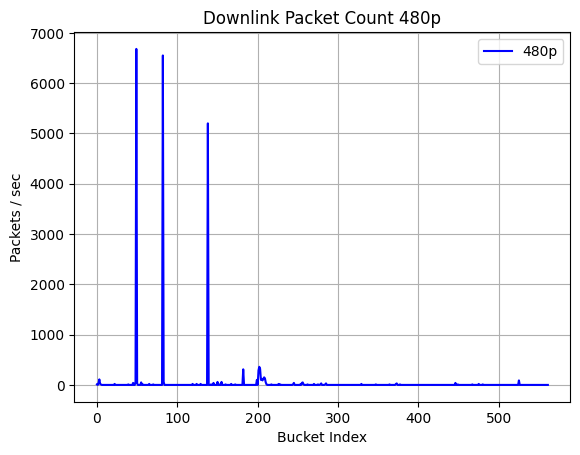

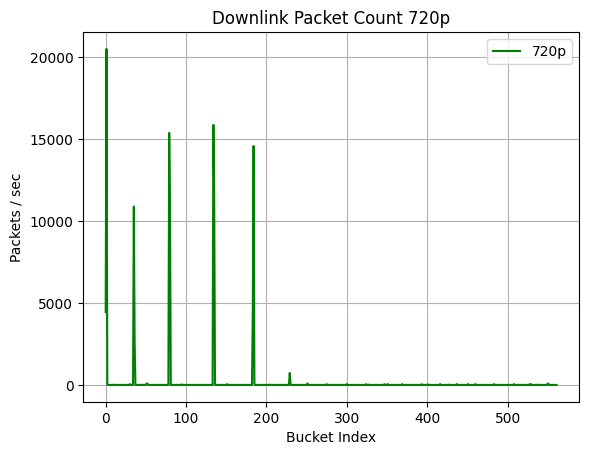

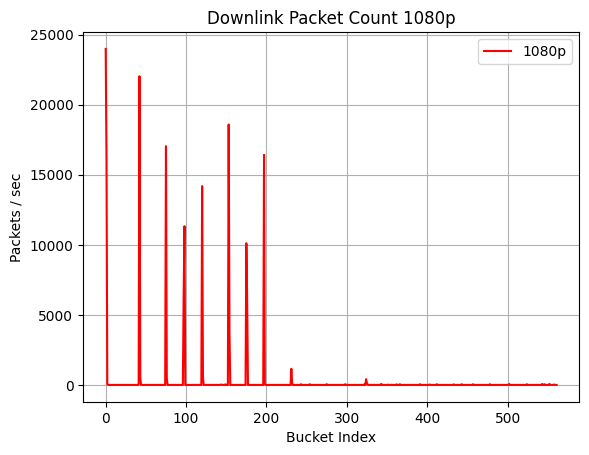

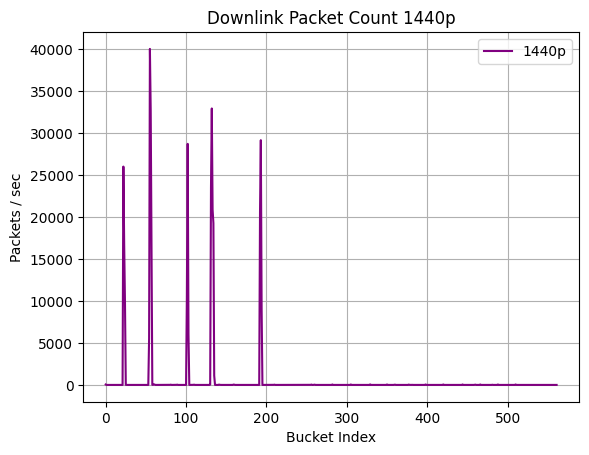

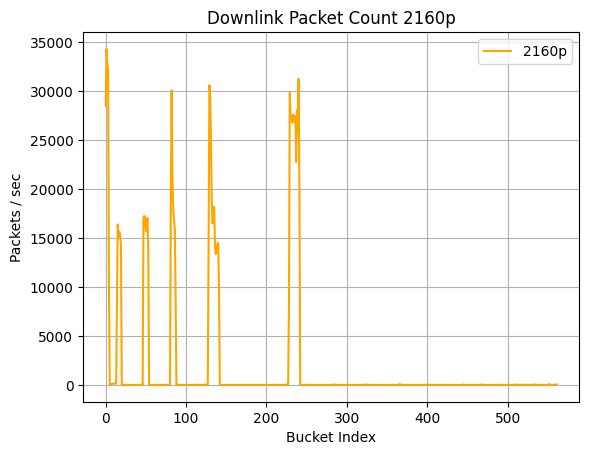

In [39]:
bucket_index_list = [i for i in range(max_buckets)]

# Define colors
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Initialize color index
color_idx = 0

for file_name in packet_bucket_map.keys():
    plt.title(f"Downlink Packet Count {file_name}")
    plt.xlabel("Bucket Index")
    plt.ylabel("Packets / sec")
    # Extract downlink packet counts for the current file
    X = [packet_bucket_map[file_name]['downlink'].get(i, 0) for i in bucket_index_list]

    # Plot the downlink packet counts
    plt.plot(bucket_index_list, X, color=colors[color_idx], label=file_name)
    
    # Increment the color index
    color_idx += 1

    plt.legend()
    plt.grid(True)
    plt.show()


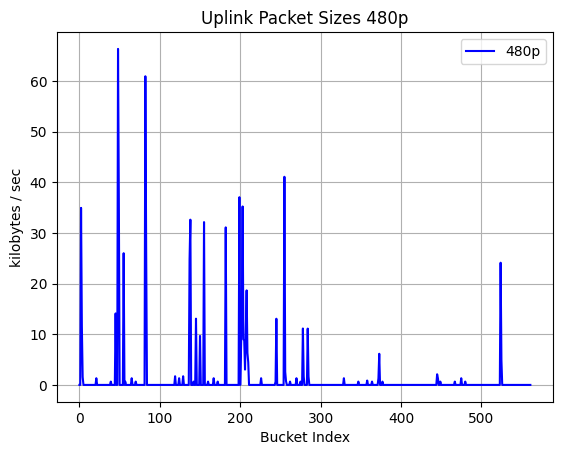

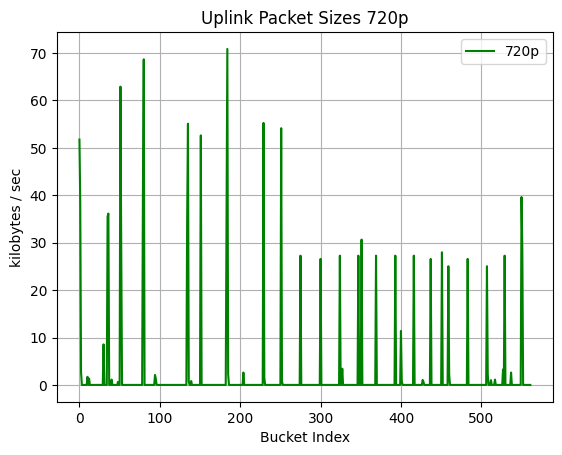

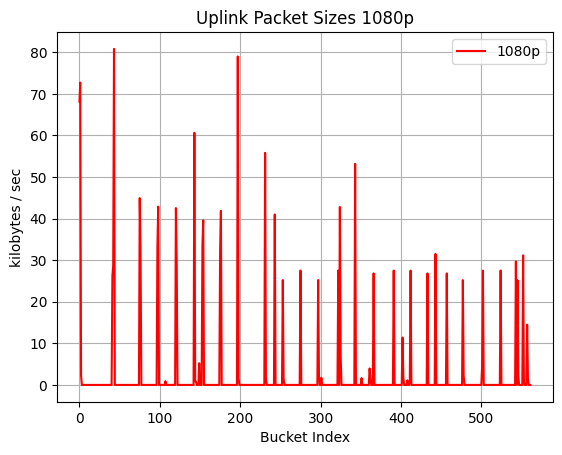

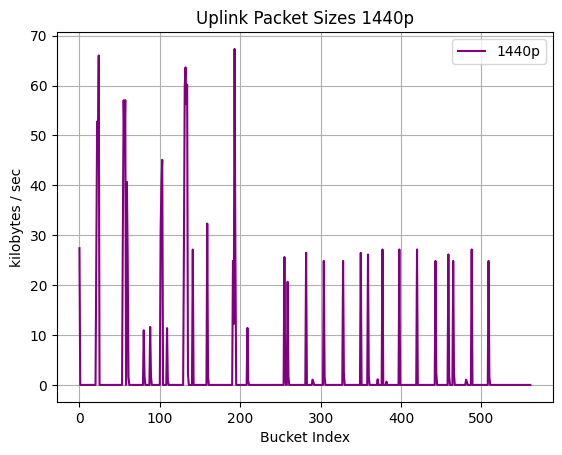

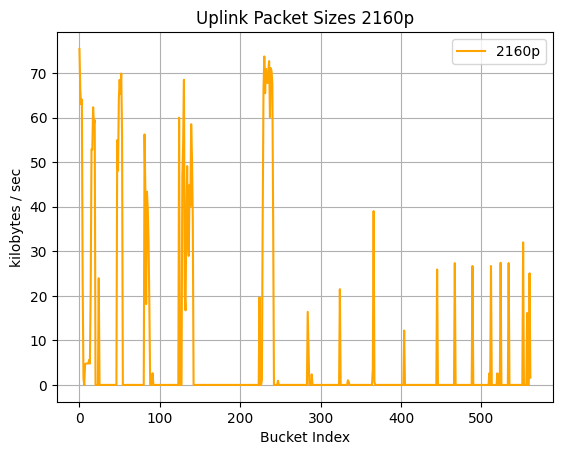

In [40]:
bucket_index_list = [i for i in range(max_buckets)]

# Define colors
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Initialize color index
color_idx = 0

for file_name in packet_bucket_map.keys():
    plt.title(f"Uplink Packet Sizes {file_name}")
    plt.xlabel("Bucket Index")
    plt.ylabel("kilobytes / sec")
    # Extract uplink packet sizes for the current file
    X = [size_bucket_map[file_name]['uplink'].get(i, 0) for i in bucket_index_list]

    # Plot the uplink packet sizes
    plt.plot(bucket_index_list, X, color=colors[color_idx], label=file_name)
    
    # Increment the color index
    color_idx += 1

    plt.legend()
    plt.grid(True)
    plt.show()


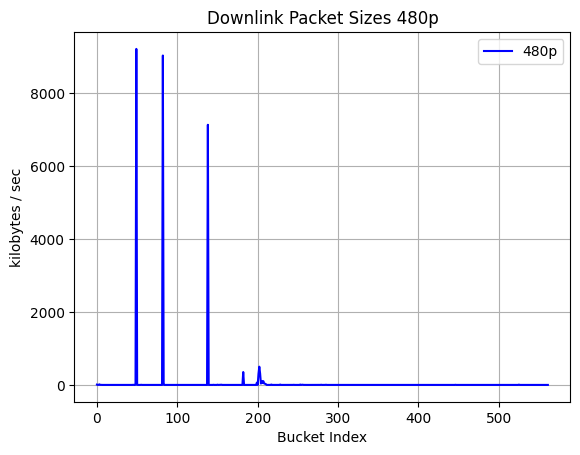

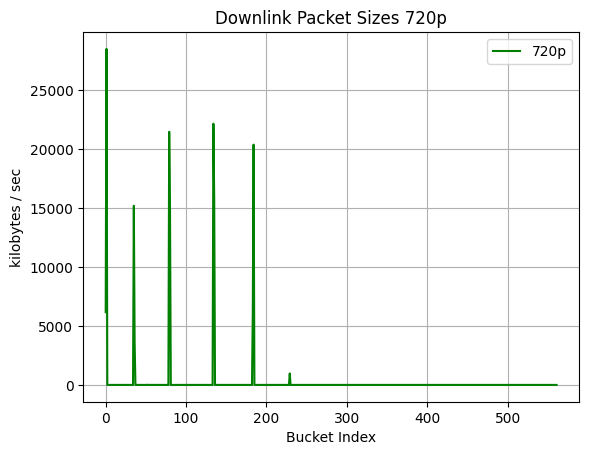

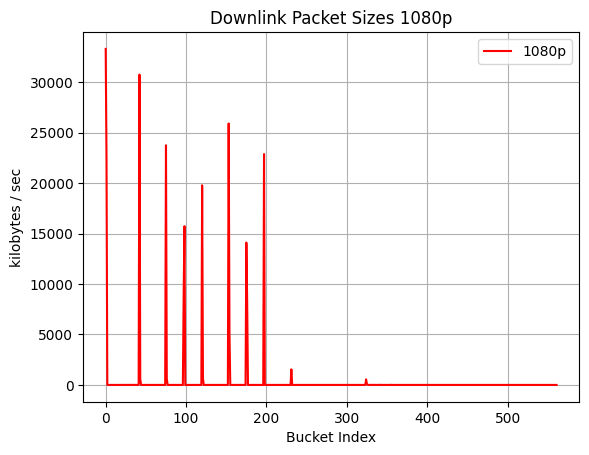

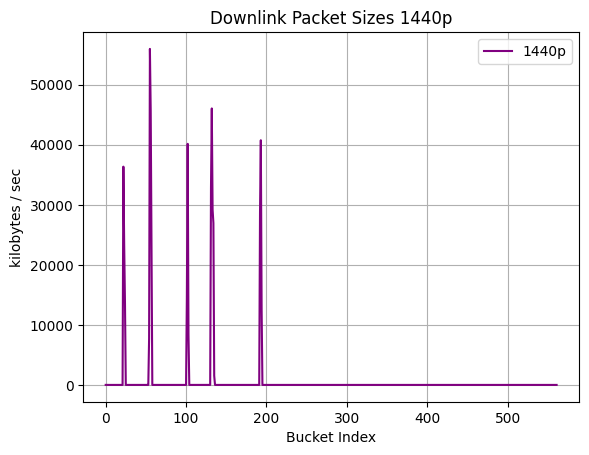

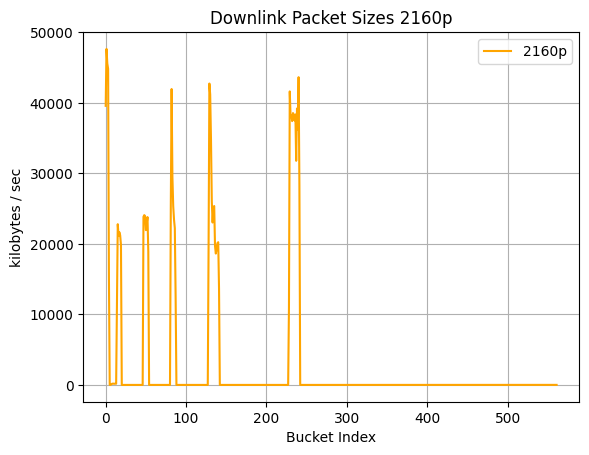

In [41]:
bucket_index_list = [i for i in range(max_buckets)]

# Define colors
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Initialize color index
color_idx = 0

for file_name in packet_bucket_map.keys():
    plt.title(f"Downlink Packet Sizes {file_name}")
    plt.xlabel("Bucket Index")
    plt.ylabel("kilobytes / sec")
    X = [size_bucket_map[file_name]['downlink'].get(i, 0) for i in bucket_index_list]
    
    plt.plot(bucket_index_list, X, color=colors[color_idx], label=file_name)
    color_idx += 1

    plt.legend()
    plt.grid(True)
    plt.show()


+-----------+----------------------+
| File Name |   Fraction Bursty    |
+-----------+----------------------+
|    480p   | 0.005703422053231939 |
|    720p   | 0.018115942028985508 |
|   1080p   | 0.023255813953488372 |
|   1440p   | 0.03522504892367906  |
|   2160p   | 0.09430604982206406  |
+-----------+----------------------+


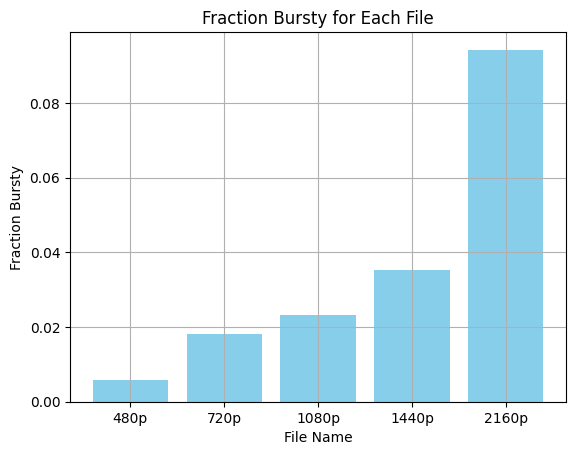

In [42]:
filenames = []
fractions = []
table = PrettyTable()
# Define table headers
table.field_names = ["File Name", "Fraction Bursty"]

for file_name in packet_bucket_map.keys():
    fraction = packet_bucket_map[file_name]['fraction_bursty']
    
    filenames.append(file_name)
    fractions.append(fraction)
    # Add data to the table
    table.add_row([file_name, fraction])

print(table)
# Plot bar chart
plt.bar(filenames, fractions, color='skyblue')

plt.xlabel('File Name')
plt.ylabel('Fraction Bursty')
plt.title('Fraction Bursty for Each File')
plt.grid(True)
plt.show()

## Imports for Task 1B

In [43]:
import pyshark
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math
from prettytable import PrettyTable

## Setting up the files

In [44]:
def extract_data(pcap_file):
    captured = pyshark.FileCapture(pcap_file)
    return captured

In [45]:
def get_ip_count_map(captured):
    ## Most occuring IP as destination is taken as the host IP
    ip_cnt = {}
    for packet in captured:
        try:
            if(packet.ip.dst not in ip_cnt):
                ip_cnt[packet.ip.dst] = 1
            else:
                ip_cnt[packet.ip.dst] += 1
        except:
            pass
    return ip_cnt

In [46]:
def set_my_ip(captured):
    max_occur_ip = None
    ip_count_map = get_ip_count_map(captured)
    mx_cnt = 0
    for key in ip_count_map.keys():
        if(ip_count_map[key] > mx_cnt):
            mx_cnt = ip_count_map[key]
            max_occur_ip = key
    return max_occur_ip

In [47]:
pcap_files = {
    'deccan': "pcapture/websites/pcap_files/deccan.pcap",
    'jagran': "pcapture/websites/pcap_files/jagran.pcap",
    'mit': "pcapture/websites/pcap_files/mit.pcap",
    'sinu': "pcapture/websites/pcap_files/sinu.pcap",
    'usach': "pcapture/websites/pcap_files/usach.pcap"
}

In [50]:
captured1 = extract_data(pcap_files['deccan'])
my_ip = set_my_ip(captured1)
my_ip

'192.168.19.125'

In [49]:
handshake_id = 2
bucket_size = 100 ## in milliseconds
default_time = -100

In [69]:
def get_dns_completion_time(captured, web_address):
    start_time = None
    end_time = None
    transaction_id = None
    for packet in captured:
        try:
            dns_id = packet.dns.id
            
            # Check if the packet contains DNS query name
            dns_destination = packet.dns.qry_name
            dns_destination.split('.')
            
            if web_address in dns_destination:
                if start_time is None:
                    start_time = packet.sniff_time.timestamp()
                    transaction_id = dns_id
                    continue
            
            if start_time is not None and end_time is None and dns_id == transaction_id:
                end_time = packet.sniff_time.timestamp()
                break
        except Exception as err:
            pass
    
    if start_time is None or end_time is None:
        return None
    
    completion_time = end_time - start_time  # in seconds
    # print(f"Completion Time {completion_time}")
    return start_time, completion_time


In [70]:
def get_ttfb(captured, init_time):
    start_time = None
    end_time = None
    for packet in captured:
        try:
            tls__ = packet.tls
            # if this works its a valid tls
            try:
                handshake_id_packet = int(packet.tls.handshake_type)
                if(handshake_id_packet == handshake_id): 
                    if start_time is None:
                        start_time = packet.sniff_time.timestamp()
                        continue
            except: 
                ## handshake does not exist. Could be the response to the message
                pass
            if start_time is None:
                continue
            tls_app_data = packet.tls.app_data  ## sanity check on if app data exists
            packet_destination_ip = packet.ip.dst
            if (start_time is not None) and (end_time is None) and (packet_destination_ip == my_ip):
                end_time = packet.sniff_time.timestamp()
                break
        except:
            pass
    
    completion_time = end_time - init_time ## in seconds
    # print(f"Completion Time {completion_time}")
    return completion_time

In [71]:
def get_packetsize_buckets(captured):
    exceptions_count = 0
    uplink_packetsize_buckets = {}
    downlink_packetsize_buckets = {}
    first_packet_time = None
    for packet in captured:
        try:
            if first_packet_time is None:
                first_packet_time = packet.sniff_time.timestamp()
            if first_packet_time is None: continue
            packet_time = packet.sniff_time.timestamp()
            time_difference_milliseconds = 1000 * (packet_time - first_packet_time)
            bucket_id = int(time_difference_milliseconds / bucket_size)
            packet_size_bytes = int(packet.length)
            last_packet_time = packet.sniff_time.timestamp()
            if(packet.ip.src == my_ip):
                if (bucket_id not in uplink_packetsize_buckets):
                    uplink_packetsize_buckets[bucket_id] = packet_size_bytes
                else:
                    uplink_packetsize_buckets[bucket_id] += packet_size_bytes
            if(packet.ip.dst == my_ip):
                if (bucket_id not in downlink_packetsize_buckets):
                    downlink_packetsize_buckets[bucket_id] = packet_size_bytes
                else:
                    downlink_packetsize_buckets[bucket_id] += packet_size_bytes

        except Exception as e:
            exceptions_count += 1
            pass
    
    for key in uplink_packetsize_buckets.keys():
        uplink_packetsize_buckets[key] /= (1000) # kB
    for key in downlink_packetsize_buckets.keys():
        downlink_packetsize_buckets[key] /= (1000) # kB
    
    return first_packet_time, downlink_packetsize_buckets, last_packet_time

In [72]:
max_buckets = 0
size_bucket_map = {}
for name in pcap_files.keys():
    size_bucket_map[name] = {}

In [73]:
for web_addr, file_addr in pcap_files.items():
    print(F"Working on {web_addr}")
    captured = extract_data(file_addr)
    start_time, dns_completion_time = get_dns_completion_time(captured, web_addr)
    ttfb = get_ttfb(captured, start_time)
    first_packet_time, downlink_packetsize_buckets, last_packet_time = get_packetsize_buckets(captured)
    total_time_milliseconds = (last_packet_time - first_packet_time) * 1000 ## milliseconds
    num_buckets = int((total_time_milliseconds + bucket_size - 1) / bucket_size)
    max_buckets = max(num_buckets, max_buckets)
    size_bucket_map[web_addr]['downlink'] = downlink_packetsize_buckets
    size_bucket_map[web_addr]['dns_completion_time'] = dns_completion_time
    size_bucket_map[web_addr]['ttfb'] = ttfb


Working on deccan
Working on jagran
Working on mit
Working on sinu
Working on usach


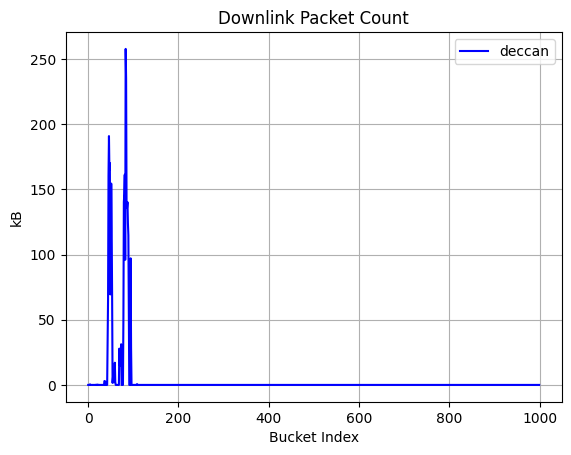

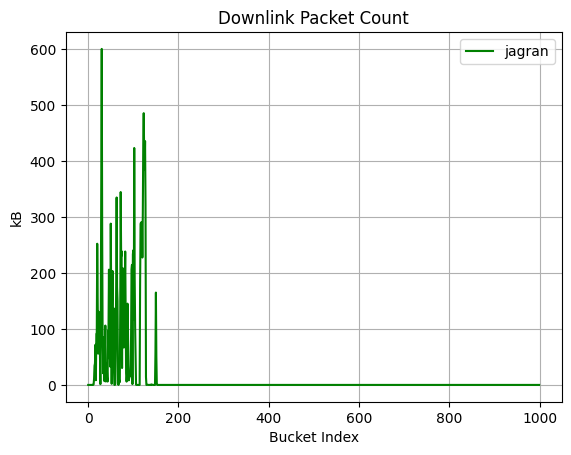

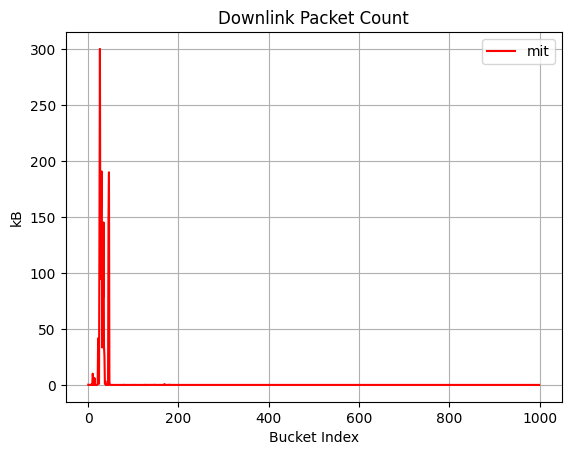

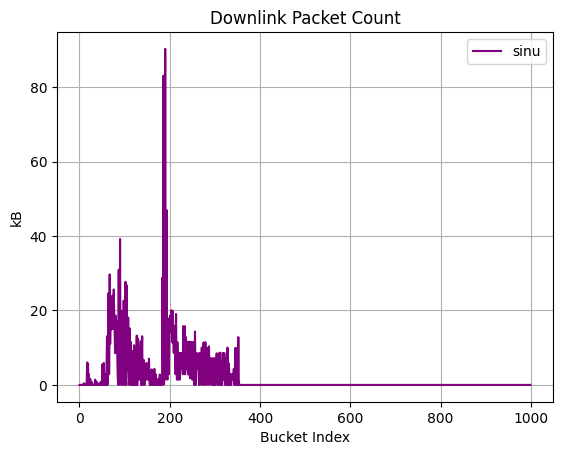

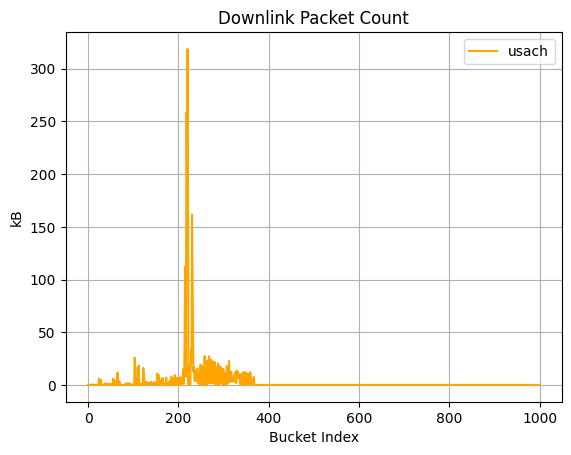

+-------------+----------------------+---------------------+
| Web Address | DNS Completion Time  |         TTFB        |
+-------------+----------------------+---------------------+
|    deccan   |  0.4733240604400635  |  4.546878099441528  |
|    jagran   | 0.04305315017700195  | 0.12353396415710449 |
|     mit     | 0.18874096870422363  |  1.6591160297393799 |
|     sinu    |  0.2283470630645752  |  0.9089720249176025 |
|    usach    | 0.013364076614379883 |  4.719866037368774  |
+-------------+----------------------+---------------------+


In [74]:
table = PrettyTable()
bucket_index_list = [i for i in range(1000)]

# Define colors
colors = ['blue', 'green', 'red', 'purple', 'orange']
table.field_names = ["Web Address", "DNS Completion Time", "TTFB"]
# Initialize color index
color_idx = 0

for file_name in size_bucket_map.keys():
    plt.title("Downlink Packet Count")
    plt.xlabel("Bucket Index")
    plt.ylabel("kB")
    # Extract uplink packet counts for the current file
    X = [size_bucket_map[file_name]['downlink'].get(i, 0) for i in bucket_index_list]

    # Plot the uplink packet counts
    plt.plot(bucket_index_list, X, color=colors[color_idx], label=file_name)
    dns_completion_time = size_bucket_map[file_name]['dns_completion_time']
    ttfb = size_bucket_map[file_name]['ttfb']
    table.add_row([file_name, dns_completion_time, ttfb])
    # Increment the color index
    color_idx += 1

    plt.legend()
    plt.grid(True)
    plt.show()

print(table)